# Method 3 - Best Ideas

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Calculate Intra-Portfolio Cap Weight

valid_data['weight'] = valid_data['market_cap_val_cur'] / valid_data.groupby(
    ['datadate', 'institution_id'])['market_cap_val_cur'].transform('sum')

# Calculate Intra-Portfolio Cap Weight Tilt

valid_data['adj_target'] = valid_data['target'] - valid_data['weight'].fillna(0)

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data.groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

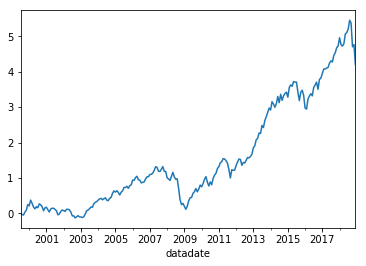

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.246481
2000-12-31   -0.074002
2001-12-31   -0.054535
2002-12-31   -0.179349
2003-12-31    0.485050
2004-12-31    0.226440
2005-12-31    0.105511
2006-12-31    0.128465
2007-12-31    0.071670
2008-12-31   -0.413146
2009-12-31    0.403302
2010-12-31    0.260841
2011-12-31   -0.019373
2012-12-31    0.201359
2013-12-31    0.489900
2014-12-31    0.113057
2015-12-31   -0.020644
2016-12-31    0.113340
2017-12-31    0.188374
2018-12-31   -0.092821
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.935
Method:                 Least Squares   F-statistic:                     842.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.15e-135
Time:                        13:37:30   Log-Likelihood:                 694.17
No. Observations:                 234   AIC:                            -1378.
Df Residuals:                     229   BIC:                            -1361.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.001      3.003      0.003       0.001       0.004
mktrf          0.9660      0.023     41.134      0.000       0.920       1.012
me             0.4595      0.027     16.822      0.000       0.406       0.513
ia            -0.0650      0.042     -1.566      0.119      -0.147       0.017
roe            0.0549      0.036      1.544      0.124      -0.015       0.125
==============================================================================
Omnibus:                       30.725   Durbin-Watson:                   2.078
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              192.819
Skew:                          -0.065   Prob(JB):                     1.35e-42
Kurtosis:                       7.445   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.935
Method:                 Least Squares   F-statistic:                     668.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          5.77e-125
Time:                        13:37:30   Log-Likelihood:                 694.17
No. Observations:                 234   AIC:                            -1378.
Df Residuals:                     229   BIC:                            -1361.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.001      3.481      0.000       0.001       0.004
mktrf          0.9660      0.032     30.357      0.000       0.904       1.028
me             0.4595      0.031     15.017      0.000       0.400       0.520
ia            -0.0650      0.087     -0.747      0.455      -0.236       0.106
roe            0.0549      0.049      1.130      0.259      -0.040       0.150
==============================================================================
Omnibus:                       30.725   Durbin-Watson:                   2.078
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              192.819
Skew:                          -0.065   Prob(JB):                     1.35e-42
Kurtosis:                       7.445   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.935
Method:                 Least Squares   F-statistic:                     820.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.88e-134
Time:                        13:37:30   Log-Likelihood:                 694.17
No. Observations:                 234   AIC:                            -1378.
Df Residuals:                     229   BIC:                            -1361.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.001      3.441      0.001       0.001       0.004
mktrf          0.9660      0.025     38.328      0.000       0.917       1.015
me             0.4595      0.030     15.272      0.000       0.401       0.519
ia            -0.0650      0.087     -0.744      0.457      -0.236       0.106
roe            0.0549      0.043      1.271      0.204      -0.030       0.139
==============================================================================
Omnibus:                       30.725   Durbin-Watson:                   2.078
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              192.819
Skew:                          -0.065   Prob(JB):                     1.35e-42
Kurtosis:                       7.445   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.925
Model:                            OLS   Adj. R-squared:                  0.923
Method:                 Least Squares   F-statistic:                     561.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          6.11e-126
Time:                        13:37:30   Log-Likelihood:                 674.69
No. Observations:                 234   AIC:                            -1337.
Df Residuals:                     228   BIC:                            -1317.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0028      0.001      2.997      0.003       0.001       0.005
mktrf          0.9569      0.026     37.335      0.000       0.906       1.007
smb            0.4612      0.034     13.638      0.000       0.395       0.528
hml           -0.0578      0.040     -1.449      0.149      -0.136       0.021
rmw           -0.0107      0.045     -0.237      0.813      -0.100       0.078
cma            0.0551      0.057      0.961      0.337      -0.058       0.168
==============================================================================
Omnibus:                       24.781   Durbin-Watson:                   2.081
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              114.799
Skew:                          -0.090   Prob(JB):                     1.18e-25
Kurtosis:                       6.427   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.925
Model:                            OLS   Adj. R-squared:                  0.923
Method:                 Least Squares   F-statistic:                     691.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.39e-135
Time:                        13:37:30   Log-Likelihood:                 674.69
No. Observations:                 234   AIC:                            -1337.
Df Residuals:                     228   BIC:                            -1317.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0028      0.001      2.856      0.004       0.001       0.005
mktrf          0.9569      0.037     26.096      0.000       0.885       1.029
smb            0.4612      0.042     10.896      0.000       0.378       0.544
hml           -0.0578      0.069     -0.836      0.403      -0.193       0.078
rmw           -0.0107      0.070     -0.154      0.878      -0.147       0.126
cma            0.0551      0.131      0.420      0.674      -0.202       0.312
==============================================================================
Omnibus:                       24.781   Durbin-Watson:                   2.081
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              114.799
Skew:                          -0.090   Prob(JB):                     1.18e-25
Kurtosis:                       6.427   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.925
Model:                            OLS   Adj. R-squared:                  0.923
Method:                 Least Squares   F-statistic:                     888.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.86e-147
Time:                        13:37:30   Log-Likelihood:                 674.69
No. Observations:                 234   AIC:                            -1337.
Df Residuals:                     228   BIC:                            -1317.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0028      0.001      2.760      0.006       0.001       0.005
mktrf          0.9569      0.035     27.475      0.000       0.889       1.025
smb            0.4612      0.042     11.046      0.000       0.379       0.543
hml           -0.0578      0.073     -0.789      0.430      -0.201       0.086
rmw           -0.0107      0.073     -0.147      0.883      -0.153       0.132
cma            0.0551      0.142      0.389      0.697      -0.223       0.333
==============================================================================
Omnibus:                       24.781   Durbin-Watson:                   2.081
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              114.799
Skew:                          -0.090   Prob(JB):                     1.18e-25
Kurtosis:                       6.427   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.932
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                     780.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          4.26e-132
Time:                        13:37:30   Log-Likelihood:                 685.77
No. Observations:                 234   AIC:                            -1362.
Df Residuals:                     229   BIC:                            -1344.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.001      2.617      0.009       0.001       0.004
mktrf          1.0146      0.022     45.269      0.000       0.970       1.059
smb            0.3976      0.028     14.212      0.000       0.342       0.453
hml            0.0764      0.028      2.749      0.006       0.022       0.131
umd            0.1143      0.018      6.271      0.000       0.078       0.150
==============================================================================
Omnibus:                       32.370   Durbin-Watson:                   1.880
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              163.370
Skew:                          -0.323   Prob(JB):                     3.35e-36
Kurtosis:                       7.042   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.932
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                     699.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          4.51e-127
Time:                        13:37:30   Log-Likelihood:                 685.77
No. Observations:                 234   AIC:                            -1362.
Df Residuals:                     229   BIC:                            -1344.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.001      2.616      0.009       0.001       0.004
mktrf          1.0146      0.033     30.664      0.000       0.950       1.079
smb            0.3976      0.035     11.386      0.000       0.329       0.466
hml            0.0764      0.059      1.300      0.194      -0.039       0.192
umd            0.1143      0.037      3.068      0.002       0.041       0.187
==============================================================================
Omnibus:                       32.370   Durbin-Watson:                   1.880
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              163.370
Skew:                          -0.323   Prob(JB):                     3.35e-36
Kurtosis:                       7.042   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.932
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                     1077.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          3.49e-147
Time:                        13:37:30   Log-Likelihood:                 685.77
No. Observations:                 234   AIC:                            -1362.
Df Residuals:                     229   BIC:                            -1344.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.001      2.690      0.007       0.001       0.004
mktrf          1.0146      0.027     37.021      0.000       0.961       1.068
smb            0.3976      0.032     12.262      0.000       0.334       0.461
hml            0.0764      0.060      1.264      0.206      -0.042       0.195
umd            0.1143      0.034      3.373      0.001       0.048       0.181
==============================================================================
Omnibus:                       32.370   Durbin-Watson:                   1.880
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              163.370
Skew:                          -0.323   Prob(JB):                     3.35e-36
Kurtosis:                       7.042   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.919
Method:                 Least Squares   F-statistic:                     337.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.65e-62
Time:                        13:37:30   Log-Likelihood:                 330.52
No. Observations:                 120   AIC:                            -651.0
Df Residuals:                     115   BIC:                            -637.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.002      1.792      0.076      -0.000       0.006
mktrf          0.9977      0.041     24.603      0.000       0.917       1.078
me             0.4694      0.040     11.720      0.000       0.390       0.549
ia            -0.0586      0.063     -0.934      0.352      -0.183       0.066
roe            0.1248      0.056      2.248      0.027       0.015       0.235
==============================================================================
Omnibus:                       14.475   Durbin-Watson:                   2.168
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               47.786
Skew:                          -0.170   Prob(JB):                     4.20e-11
Kurtosis:                       6.073   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.919
Method:                 Least Squares   F-statistic:                     311.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.09e-60
Time:                        13:37:30   Log-Likelihood:                 330.52
No. Observations:                 120   AIC:                            -651.0
Df Residuals:                     115   BIC:                            -637.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      2.466      0.014       0.001       0.005
mktrf          0.9977      0.057     17.564      0.000       0.886       1.109
me             0.4694      0.041     11.413      0.000       0.389       0.550
ia            -0.0586      0.107     -0.548      0.583      -0.268       0.151
roe            0.1248      0.065      1.907      0.056      -0.003       0.253
==============================================================================
Omnibus:                       14.475   Durbin-Watson:                   2.168
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               47.786
Skew:                          -0.170   Prob(JB):                     4.20e-11
Kurtosis:                       6.073   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.919
Method:                 Least Squares   F-statistic:                     404.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.05e-66
Time:                        13:37:30   Log-Likelihood:                 330.52
No. Observations:                 120   AIC:                            -651.0
Df Residuals:                     115   BIC:                            -637.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      2.781      0.005       0.001       0.005
mktrf          0.9977      0.040     24.686      0.000       0.918       1.077
me             0.4694      0.041     11.314      0.000       0.388       0.551
ia            -0.0586      0.105     -0.557      0.578      -0.265       0.148
roe            0.1248      0.045      2.763      0.006       0.036       0.213
==============================================================================
Omnibus:                       14.475   Durbin-Watson:                   2.168
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               47.786
Skew:                          -0.170   Prob(JB):                     4.20e-11
Kurtosis:                       6.073   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.898
Method:                 Least Squares   F-statistic:                     211.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.88e-56
Time:                        13:37:30   Log-Likelihood:                 317.57
No. Observations:                 120   AIC:                            -623.1
Df Residuals:                     114   BIC:                            -606.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0038      0.002      2.185      0.031       0.000       0.007
mktrf          0.9840      0.048     20.567      0.000       0.889       1.079
smb            0.4710      0.054      8.693      0.000       0.364       0.578
hml           -0.0967      0.066     -1.457      0.148      -0.228       0.035
rmw            0.0438      0.078      0.559      0.577      -0.111       0.199
cma            0.1151      0.086      1.341      0.182      -0.055       0.285
==============================================================================
Omnibus:                        7.794   Durbin-Watson:                   2.211
Prob(Omnibus):                  0.020   Jarque-Bera (JB):               13.122
Skew:                          -0.205   Prob(JB):                      0.00141
Kurtosis:                       4.567   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.898
Method:                 Least Squares   F-statistic:                     377.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.73e-69
Time:                        13:37:30   Log-Likelihood:                 317.57
No. Observations:                 120   AIC:                            -623.1
Df Residuals:                     114   BIC:                            -606.4
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0038      0.002      2.320      0.020       0.001       0.007
mktrf          0.9840      0.074     13.381      0.000       0.840       1.128
smb            0.4710      0.064      7.371      0.000       0.346       0.596
hml           -0.0967      0.110     -0.882      0.378      -0.312       0.118
rmw            0.0438      0.125      0.350      0.726      -0.201       0.289
cma            0.1151      0.167      0.688      0.492      -0.213       0.443
==============================================================================
Omnibus:                        7.794   Durbin-Watson:                   2.211
Prob(Omnibus):                  0.020   Jarque-Bera (JB):               13.122
Skew:                          -0.205   Prob(JB):                      0.00141
Kurtosis:                       4.567   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.898
Method:                 Least Squares   F-statistic:                     392.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.43e-70
Time:                        13:37:30   Log-Likelihood:                 317.57
No. Observations:                 120   AIC:                            -623.1
Df Residuals:                     114   BIC:                            -606.4
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0038      0.002      2.352      0.019       0.001       0.007
mktrf          0.9840      0.072     13.591      0.000       0.842       1.126
smb            0.4710      0.065      7.267      0.000       0.344       0.598
hml           -0.0967      0.119     -0.812      0.417      -0.330       0.137
rmw            0.0438      0.138      0.318      0.750      -0.226       0.313
cma            0.1151      0.177      0.650      0.516      -0.232       0.462
==============================================================================
Omnibus:                        7.794   Durbin-Watson:                   2.211
Prob(Omnibus):                  0.020   Jarque-Bera (JB):               13.122
Skew:                          -0.205   Prob(JB):                      0.00141
Kurtosis:                       4.567   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.916
Model:                            OLS   Adj. R-squared:                  0.913
Method:                 Least Squares   F-statistic:                     313.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.88e-61
Time:                        13:37:31   Log-Likelihood:                 326.48
No. Observations:                 120   AIC:                            -643.0
Df Residuals:                     115   BIC:                            -629.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0040      0.002      2.613      0.010       0.001       0.007
mktrf          1.0494      0.037     28.402      0.000       0.976       1.123
smb            0.3662      0.042      8.706      0.000       0.283       0.450
hml            0.0870      0.042      2.064      0.041       0.004       0.170
umd            0.1388      0.026      5.341      0.000       0.087       0.190
==============================================================================
Omnibus:                       21.961   Durbin-Watson:                   1.970
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               57.491
Skew:                          -0.638   Prob(JB):                     3.28e-13
Kurtosis:                       6.142   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.916
Model:                            OLS   Adj. R-squared:                  0.913
Method:                 Least Squares   F-statistic:                     428.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.72e-68
Time:                        13:37:31   Log-Likelihood:                 326.48
No. Observations:                 120   AIC:                            -643.0
Df Residuals:                     115   BIC:                            -629.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0040      0.001      3.149      0.002       0.002       0.006
mktrf          1.0494      0.051     20.402      0.000       0.949       1.150
smb            0.3662      0.046      7.958      0.000       0.276       0.456
hml            0.0870      0.071      1.225      0.220      -0.052       0.226
umd            0.1388      0.045      3.104      0.002       0.051       0.226
==============================================================================
Omnibus:                       21.961   Durbin-Watson:                   1.970
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               57.491
Skew:                          -0.638   Prob(JB):                     3.28e-13
Kurtosis:                       6.142   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.916
Model:                            OLS   Adj. R-squared:                  0.913
Method:                 Least Squares   F-statistic:                     728.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.16e-80
Time:                        13:37:31   Log-Likelihood:                 326.48
No. Observations:                 120   AIC:                            -643.0
Df Residuals:                     115   BIC:                            -629.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0040      0.001      3.861      0.000       0.002       0.006
mktrf          1.0494      0.037     28.470      0.000       0.977       1.122
smb            0.3662      0.037      9.894      0.000       0.294       0.439
hml            0.0870      0.071      1.222      0.222      -0.053       0.226
umd            0.1388      0.034      4.044      0.000       0.072       0.206
==============================================================================
Omnibus:                       21.961   Durbin-Watson:                   1.970
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               57.491
Skew:                          -0.638   Prob(JB):                     3.28e-13
Kurtosis:                       6.142   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                     954.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.93e-84
Time:                        13:37:31   Log-Likelihood:                 402.83
No. Observations:                 114   AIC:                            -795.7
Df Residuals:                     109   BIC:                            -782.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      3.720      0.000       0.001       0.004
mktrf          0.9506      0.021     44.749      0.000       0.908       0.993
me             0.4258      0.033     12.983      0.000       0.361       0.491
ia            -0.1615      0.045     -3.550      0.001      -0.252      -0.071
roe           -0.1554      0.040     -3.887      0.000      -0.235      -0.076
==============================================================================
Omnibus:                        1.089   Durbin-Watson:                   1.583
Prob(Omnibus):                  0.580   Jarque-Bera (JB):                1.161
Skew:                           0.221   Prob(JB):                        0.559
Kurtosis:                       2.779   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                     1473.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.27e-94
Time:                        13:37:31   Log-Likelihood:                 402.83
No. Observations:                 114   AIC:                            -795.7
Df Residuals:                     109   BIC:                            -782.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      2.909      0.004       0.001       0.004
mktrf          0.9506      0.015     62.463      0.000       0.921       0.980
me             0.4258      0.029     14.654      0.000       0.369       0.483
ia            -0.1615      0.055     -2.936      0.003      -0.269      -0.054
roe           -0.1554      0.045     -3.484      0.000      -0.243      -0.068
==============================================================================
Omnibus:                        1.089   Durbin-Watson:                   1.583
Prob(Omnibus):                  0.580   Jarque-Bera (JB):                1.161
Skew:                           0.221   Prob(JB):                        0.559
Kurtosis:                       2.779   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                     2081.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          6.50e-102
Time:                        13:37:31   Log-Likelihood:                 402.83
No. Observations:                 114   AIC:                            -795.7
Df Residuals:                     109   BIC:                            -782.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      2.450      0.014       0.001       0.005
mktrf          0.9506      0.014     66.583      0.000       0.923       0.979
me             0.4258      0.029     14.873      0.000       0.370       0.482
ia            -0.1615      0.061     -2.660      0.008      -0.281      -0.043
roe           -0.1554      0.040     -3.863      0.000      -0.234      -0.077
==============================================================================
Omnibus:                        1.089   Durbin-Watson:                   1.583
Prob(Omnibus):                  0.580   Jarque-Bera (JB):                1.161
Skew:                           0.221   Prob(JB):                        0.559
Kurtosis:                       2.779   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                     847.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.86e-85
Time:                        13:37:31   Log-Likelihood:                 409.11
No. Observations:                 114   AIC:                            -806.2
Df Residuals:                     108   BIC:                            -789.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.001      2.495      0.014       0.000       0.003
mktrf          0.9643      0.019     50.061      0.000       0.926       1.002
smb            0.4121      0.031     13.179      0.000       0.350       0.474
hml           -0.0620      0.040     -1.555      0.123      -0.141       0.017
rmw           -0.2345      0.049     -4.802      0.000      -0.331      -0.138
cma           -0.0990      0.062     -1.598      0.113      -0.222       0.024
==============================================================================
Omnibus:                        0.274   Durbin-Watson:                   1.649
Prob(Omnibus):                  0.872   Jarque-Bera (JB):                0.307
Skew:                           0.114   Prob(JB):                        0.857
Kurtosis:                       2.886   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                     974.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.35e-88
Time:                        13:37:31   Log-Likelihood:                 409.11
No. Observations:                 114   AIC:                            -806.2
Df Residuals:                     108   BIC:                            -789.8
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.001      1.888      0.059   -6.49e-05       0.003
mktrf          0.9643      0.015     64.393      0.000       0.935       0.994
smb            0.4121      0.031     13.205      0.000       0.351       0.473
hml           -0.0620      0.032     -1.967      0.049      -0.124      -0.000
rmw           -0.2345      0.040     -5.913      0.000      -0.312      -0.157
cma           -0.0990      0.061     -1.626      0.104      -0.218       0.020
==============================================================================
Omnibus:                        0.274   Durbin-Watson:                   1.649
Prob(Omnibus):                  0.872   Jarque-Bera (JB):                0.307
Skew:                           0.114   Prob(JB):                        0.857
Kurtosis:                       2.886   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                     1714.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          4.05e-101
Time:                        13:37:31   Log-Likelihood:                 409.11
No. Observations:                 114   AIC:                            -806.2
Df Residuals:                     108   BIC:                            -789.8
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.001      1.608      0.108      -0.000       0.004
mktrf          0.9643      0.013     72.206      0.000       0.938       0.990
smb            0.4121      0.030     13.917      0.000       0.354       0.470
hml           -0.0620      0.028     -2.231      0.026      -0.116      -0.008
rmw           -0.2345      0.041     -5.652      0.000      -0.316      -0.153
cma           -0.0990      0.059     -1.668      0.095      -0.215       0.017
==============================================================================
Omnibus:                        0.274   Durbin-Watson:                   1.649
Prob(Omnibus):                  0.872   Jarque-Bera (JB):                0.307
Skew:                           0.114   Prob(JB):                        0.857
Kurtosis:                       2.886   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     833.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.00e-80
Time:                        13:37:31   Log-Likelihood:                 395.36
No. Observations:                 114   AIC:                            -780.7
Df Residuals:                     109   BIC:                            -767.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.001      1.247      0.215      -0.001       0.002
mktrf          0.9902      0.021     46.070      0.000       0.948       1.033
smb            0.4605      0.034     13.739      0.000       0.394       0.527
hml           -0.0216      0.035     -0.626      0.532      -0.090       0.047
umd            0.0249      0.026      0.955      0.342      -0.027       0.076
==============================================================================
Omnibus:                        0.681   Durbin-Watson:                   1.501
Prob(Omnibus):                  0.711   Jarque-Bera (JB):                0.759
Skew:                           0.008   Prob(JB):                        0.684
Kurtosis:                       2.601   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     797.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.06e-79
Time:                        13:37:31   Log-Likelihood:                 395.36
No. Observations:                 114   AIC:                            -780.7
Df Residuals:                     109   BIC:                            -767.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.001      0.959      0.338      -0.001       0.003
mktrf          0.9902      0.019     51.073      0.000       0.952       1.028
smb            0.4605      0.029     15.778      0.000       0.403       0.518
hml           -0.0216      0.034     -0.637      0.524      -0.088       0.045
umd            0.0249      0.018      1.402      0.161      -0.010       0.060
==============================================================================
Omnibus:                        0.681   Durbin-Watson:                   1.501
Prob(Omnibus):                  0.711   Jarque-Bera (JB):                0.759
Skew:                           0.008   Prob(JB):                        0.684
Kurtosis:                       2.601   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     1052.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.58e-86
Time:                        13:37:31   Log-Likelihood:                 395.36
No. Observations:                 114   AIC:                            -780.7
Df Residuals:                     109   BIC:                            -767.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.001      0.870      0.384      -0.001       0.003
mktrf          0.9902      0.018     56.321      0.000       0.956       1.025
smb            0.4605      0.024     19.393      0.000       0.414       0.507
hml           -0.0216      0.031     -0.706      0.480      -0.082       0.038
umd            0.0249      0.017      1.427      0.154      -0.009       0.059
==============================================================================
Omnibus:                        0.681   Durbin-Watson:                   1.501
Prob(Omnibus):                  0.711   Jarque-Bera (JB):                0.759
Skew:                           0.008   Prob(JB):                        0.684
Kurtosis:                       2.601   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""